# Using SVM to Classify Famous Faces

In this program we will use an SVM classifier on the Labeled Faces in the Wild (LFW) dataset. In this model we use Principal Component Analysis (PCA) to reduce the dimensionality of the data and indentify the optimal parameters for an SVM classifier employing a Radial Basis Function (RBF) kernel.

We begin by importing the data, assigning X and y and plotting some of the images. Each sample in the dataset is comprised of 2914 features. Each feature represents a grayscale value, and when the features are reshaped into a 62x47 grid, the sample forms an image when passed to imshow.

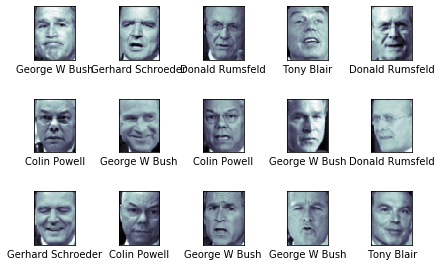

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


faces = fetch_lfw_people(min_faces_per_person = 100)
X = faces.data
y = faces.target
names = faces.target_names

# plot some of the images
fig, axes = plt.subplots(3, 5)
# reshape data into 1348 images of 62x47 pixels
images = X.reshape(1140, 62, 47)
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap = 'bone')
    # remove xticks and yticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(names[y[i]])
fig.tight_layout()
plt.show()

We will utilise a pipeline in this program to significantly reduce computational time.

In [41]:
# Implement Principal Component Analysis (PCA) to identify and utilise the most important features
# whiten helps reduce the correlation between adjacent pixels in an image problem
pca = PCA(n_components = 150, whiten = True, random_state = 31)
# create support vector classifier with rbf kernel
svc = SVC(kernel = 'rbf', class_weight = 'balanced')
# generate pipeline
pipeline = Pipeline(steps = [('pca', pca), ('svc', svc)])

In [42]:
# separate the data in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 13)

We will define a suitable scoring metric to use with GridSearchCV as the inbuilt scoring methods are not suited to SVM classifiers. Our metric will use the confusion matrix to identify the number of misclassifications made. As the number of misclassifications increases, the metric decreases.

In [43]:
# define scoring metric for GridSearchCV
def scoring_metric(svc, X, y):
    y_pred = svc.predict(X)
    conf_mat = confusion_matrix(y, y_pred)
    # subtract the number of misclassifications divided by total samples from 1
    total = sum(sum(conf_mat))
    # correct classifications are the diagonal elements
    correct = conf_mat.trace()
    misclass = total - correct
    # divide by total samples and subtract from 1 so that as the number of misclassifications decreases, the metric increases
    metric = 1 - misclass/y.shape[0]
    return metric

Next we define our parameter spaces and parameter grid, before fitting the GridSearchCV object to the training data.

In [44]:
# define spaces for C and gamma from which GridSearchCV will search for the optimal values
c_space = np.array([9.6, 9.8, 10, 10.2])
gamma_space = np.array([0.00096, 0.00098, 0.001, 0.0012])
param_grid = {'svc__C': c_space, 'svc__gamma': gamma_space}
# define GridSearchCV object
svc_cv = GridSearchCV(pipeline, param_grid, scoring = scoring_metric, cv = 5)
# fit to training data
svc_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=150, random_state=31,
                                            svd_solver='auto', tol=0.0,
                                            whiten=True)),
                                       ('svc',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight='balanced', coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
       

Now we will use the optimal parameters identified from the grid search to make predictions on the test data.

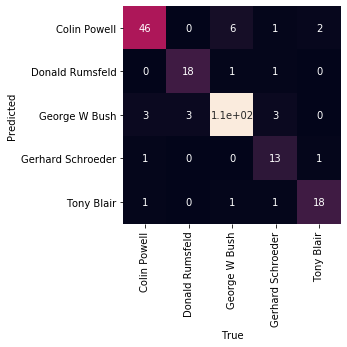

                   precision    recall  f1-score   support

     Colin Powell       0.84      0.90      0.87        51
  Donald Rumsfeld       0.90      0.86      0.88        21
    George W Bush       0.92      0.93      0.93       116
Gerhard Schroeder       0.87      0.68      0.76        19
       Tony Blair       0.86      0.86      0.86        21

         accuracy                           0.89       228
        macro avg       0.88      0.85      0.86       228
     weighted avg       0.89      0.89      0.89       228



In [45]:
# generate predicted y values for the test data
svc_optimal = svc_cv.best_estimator_
y_pred = svc_optimal.predict(X_test)
# print confusion matrix and classification report
conf_mat = confusion_matrix(y_test, y_pred)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2 = sns.heatmap(conf_mat.T, square = 'True', annot = True, cbar = False, 
                  xticklabels = names, yticklabels = names)
ax2.set_xlabel('True')
ax2.set_ylabel('Predicted')
plt.show()
print(classification_report(y_test, y_pred, target_names = names))

Finally, we plot some of the test images along with their predicted names.

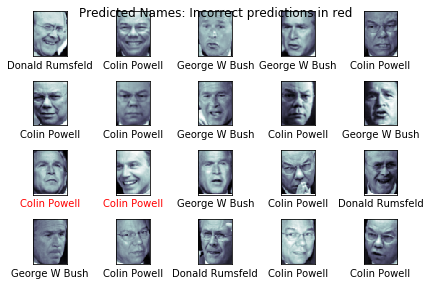

In [46]:
fig, axes = plt.subplots(4, 5)
# reshape data into 270 images of 62x47 pixels
test_images = X_test.reshape(228, 62, 47)
for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap = 'bone')
    # remove xticks and yticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(names[y_pred[i]], color = 'k' if y_pred[i] == y_test[i] else 'r')
fig.suptitle('Predicted Names: Incorrect predictions in red')
fig.tight_layout()
plt.show()